In [ ]:
# Recommendation
# Code by Stephen Spivack and Pascal Wallisch
# Date: 12-08-21

In [ ]:
# In this lab, we will analyze song ratings from a single Spotify user.
# Our goal is to use the auditory features of each song to predict whether
# the user will like a given song.

# Because many of the auditory features are correlated, we will first have
# to use PCA to reduce the dimensionality of the data. Then we can build
# classification models that make predictions.

In [1]:
# 0. Init
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import plot_roc_curve

In [2]:
# 1. Loader
# source: https://www.kaggle.com/bricevergnou/spotify-recommendation
data = pd.read_csv('spotifyData.csv')
data.head() # display the first 5 rows

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,liked
0,0.803,0.6240,7,-6.764,0,0.0477,0.451,0.000734,0.1000,0.6280,95.968,304524,4,0
1,0.762,0.7030,10,-7.951,0,0.3060,0.206,0.000000,0.0912,0.5190,151.329,247178,4,1
2,0.261,0.0149,1,-27.528,1,0.0419,0.992,0.897000,0.1020,0.0382,75.296,286987,4,0
3,0.722,0.7360,3,-6.994,0,0.0585,0.431,0.000001,0.1230,0.5820,89.860,208920,4,1
4,0.787,0.5720,1,-7.516,1,0.2220,0.145,0.000000,0.0753,0.6470,155.117,179413,4,1


In [3]:
# 2. Format data for PCA:

# Remove categorical features:
data = data.drop(['key', 'mode', 'time_signature'],axis=1)

# Extract predictors and outcomes:
y = data['liked'].to_numpy()
x = data.drop(['liked'],axis=1).to_numpy()

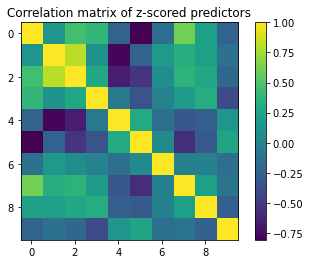

In [4]:
# 3. Preprocess data for PCA:

# Z-score the predictors matrix:
zscoredX = stats.zscore(x)

# Visualize the correlation matrix:
r = np.corrcoef(zscoredX,rowvar=False)
plt.imshow(r) 
plt.title('Correlation matrix of z-scored predictors')
plt.colorbar()
plt.show()

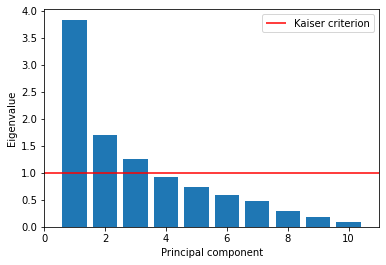

Proportion variance explained by the first 3 PCs: 0.675


In [5]:
# 4. Run PCA:
pca = PCA().fit(zscoredX)
eigVals = pca.explained_variance_
loadings = pca.components_*-1
transformedData = pca.fit_transform(zscoredX)*-1

# Plot eigenvalues:
numPredictors = np.size(zscoredX,axis=1)
plt.bar(np.linspace(1,numPredictors,numPredictors),eigVals)
plt.hlines(1,0,11,colors='red')
plt.xlim([0,11])
plt.xlabel('Principal component')
plt.ylabel('Eigenvalue')
plt.legend(['Kaiser criterion'])
plt.show()

# Here we use the kaiser criterion to select the principal components.
# Other methods of consideration: 1. elbow criterion, 2. Horn's parallel 
# method, and 3. first n factors to explain >= 90% of the variance. These 
# select 1, 2 and 6 factors, respectively.

print('Proportion variance explained by the first 3 PCs:',np.sum(eigVals[:3]/np.sum(eigVals)).round(3))

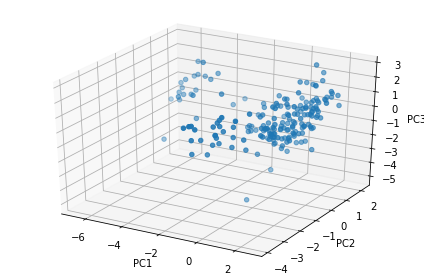

In [6]:
# Plot first 3 principal components:
fig = plt.figure()
ax = fig.add_subplot(111,projection='3d')
ax.scatter(transformedData[:,0],transformedData[:,1],transformedData[:,2])
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
plt.tight_layout()
plt.show()

In [7]:
# Format data for machine learning models:
numDimensions = 3 # Selected by the Kaiser criterion from our PCA
x = transformedData[:,0:numDimensions]

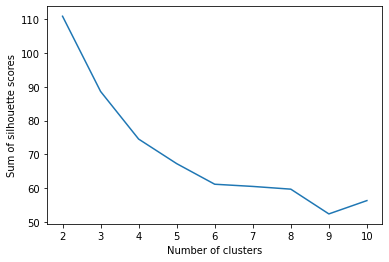

In [8]:
# 5. Unsupervised learning

# Run kMeans and compute sum of silhouettes:
numClusters = 9 # from 2 to 10
clusterSums = np.empty([numClusters,1])*np.NaN
for ii in range(numClusters):
    kMeans = KMeans(n_clusters = int(ii+2)).fit(x) 
    cId = kMeans.labels_ 
    s = silhouette_samples(x,cId) 
    clusterSums[ii] = np.sum(s) 
    
# Plot score for each cluster size:
plt.plot(np.linspace(2,numClusters+1,numClusters),clusterSums)
plt.xlabel('Number of clusters')
plt.ylabel('Sum of silhouette scores')
plt.show()

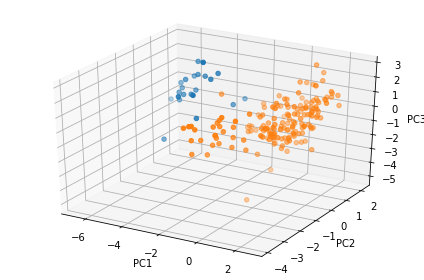

In [9]:
# Recompute k-means using optimal number clusters:
numClusters = 2 # Selected from our sum of silhouettes
kMeans = KMeans(n_clusters = 2).fit(x) 
cId = kMeans.labels_ 

# Plot the color-coded data:
fig = plt.figure()
ax = fig.add_subplot(111,projection='3d')
for ii in range(numClusters):
    plotIndex = np.argwhere(cId == ii)
    ax.scatter(transformedData[plotIndex,0],transformedData[plotIndex,1],transformedData[plotIndex,2],marker='o')
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
plt.tight_layout()
plt.show()

In [ ]:
# 6. Supervised learning models

# This time around, we will build our models with one portion of the 
# data and make predictions using the remaining. Specifically, we will 
# use the same models as last time - support vector machines and the 
# random forest - but this time we will build the model using a training 
# set; then we will make predictions using a test set. We will split our 
# data with two commonly used methods - (1) 80/20 split and (2) leave-one-out. 
# Then we will compute the accuracy of each to see which is better at 
# predicting music preference ratings from our auditory features that we got 
# from the PCA.

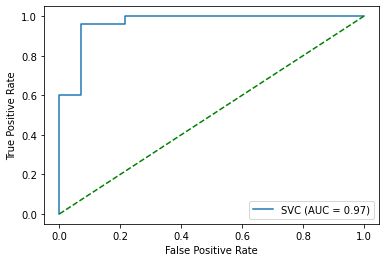

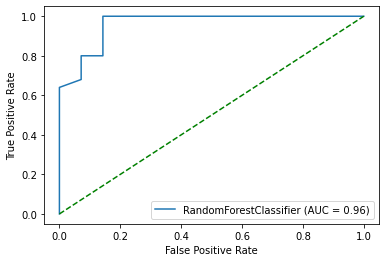

In [10]:
# Build classification models using 80-20 train-test split:

# Split the data:
xTrain, xTest, yTrain, yTest = train_test_split(x,y,test_size=0.2,random_state=0)

# Build the models with our training data:
svmModel = svm.SVC(kernel='linear').fit(xTrain,yTrain)
rfcModel = RandomForestClassifier(n_estimators=100).fit(xTrain,yTrain)

# Use the models to make predictions with our test data:
svmPredictions = svmModel.predict(xTest)
rfcPredictions = rfcModel.predict(xTest)

# Plot the ROC curve:
plot_roc_curve(svmModel,xTest,yTest)
plt.plot([0,1],[0,1],'g--')
plot_roc_curve(rfcModel,xTest,yTest)
plt.plot([0,1],[0,1],'g--')
plt.show()

In [11]:
# Build classification models using leave-one-out:
n = len(x)
svmAccuracy = np.empty([n,1])
rfcAccuracy = np.empty([n,1])
for ii in range(n):
    # Init training and test sets:
    xTrain = np.delete(x,ii,0)
    xTest = x[ii].reshape(1,np.size(xTrain,axis=1))
    yTrain = np.delete(y,ii,0)
    yTest = y[ii]
    # Build SVM model, make predictions, compute accuracy:
    svmModel = svm.SVC(kernel='linear').fit(xTrain,yTrain)
    svmPredictions = svmModel.predict(xTest)
    svmAccuracy[ii] = len(np.argwhere(svmPredictions==yTest))
    # Build RFC model, make predictions, compute accuracy:
    rfcModel = RandomForestClassifier(n_estimators=100).fit(xTrain,yTrain) # 100 trees
    rfcPredictions = rfcModel.predict(xTest)
    rfcAccuracy[ii] = len(np.argwhere(rfcPredictions==yTest))
svmAccuracy = sum(svmAccuracy)/n # average over n tests
rfcAccuracy = sum(rfcAccuracy)/n # average over n tests
print('SVM model accuracy:',float(svmAccuracy.round(3)))
print('RFC model accuracy:',float(rfcAccuracy.round(3)))

SVM model accuracy: 0.867
RFC model accuracy: 0.872


In [ ]:
# Fin. Thanks for a great semester!